# DC$\pi$BO - Non-stationary SCM and DAG (NONSTAT, i.e. edges X0->Z1, Z1->Y2)

## Imports

In [1]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append("../../src/")
sys.path.append("../..")

from src.examples.example_setups import setup_nonstat_scm
from src.utils.sem_utils.toy_sems import NonStationaryDependentSEM as NonStatSEM
from src.utils.sem_utils.sem_estimate import build_sem_hat

from src.experimental.experiments_nonstat import run_methods_replicates
from src.experimental.analyse_results import get_relevant_results, elaborate, gap_metric_standard, get_common_initial_values, get_converge_trial
from src.utils.plotting import plot_expected_opt_curve_paper

from src.methods.bo_nonstat import BO
from src.methods.dcbo_nonstat import DCBO
from src.methods.pibo_nonstat import PIBO
from src.methods.dcpibo_nonstat import DCPIBO

from matplotlib.pyplot import rc
import numpy as np
from scipy import stats
import random

random.seed(42)

## Utility Functions

In [2]:
def power_list(input_list, exponent):
    '''Raises each element of the given input_list to the desired exponent'''
    
    return_list = []
    
    for element in input_list:
        if element >= 0:
            raised_element = element**exponent
        else:
            raised_element = -(abs(element)**exponent)
        return_list.append(raised_element)
        
    return return_list

In [3]:
def compute_statistics(y_function, standard_deviation):
    '''Computes all the necessary lists associated to the Normal Distribution'''
    
    return_variates = []
    return_amps = []
    return_pdfs = []
    
    for mean in y_function:
        return_variates.append(stats.norm.rvs(mean, standard_deviation, 10))
        
        amp = np.linspace(mean-5*standard_deviation, mean+5*standard_deviation, 10)
        return_amps.append(amp)
        
        return_pdfs.append(stats.norm.pdf(amp, mean, standard_deviation))
    
    return return_variates, return_amps, return_pdfs

In [4]:
def normalise_pdfs(pdfs_list):
    '''Normalises the PDFs between 0 and 1'''
    
    return_normalised_pdfs_list = []
    
    for pdf_list in pdfs_list:
        temp_list = []
        
        pdf_min = min(pdf_list)
        pdf_max = max(pdf_list)
        
        for pdf_value in pdf_list:
            temp_list.append(round((pdf_value-pdf_min)/(pdf_max-pdf_min),2))
        
        return_normalised_pdfs_list.append(temp_list)
        
    return return_normalised_pdfs_list

In [5]:
def regret_priors(start_prior):
    '''Adds regret'''
    
    return_raised_priors = []
    
    for i in range(1,N+1):
        temp = []
        gamma = beta/i
        
        for p_list in start_prior:
            temp.append(power_list(p_list, gamma))
            
        return_raised_priors.append(temp)
    
    return return_raised_priors

In [6]:
def predict_optima_regret(iterations, time_steps, regret_priors, normalised_pdfs):
    '''Computes the prediction for each time-step and each iteration, according to the effect of gamma (regret)'''
    
    return_predictions = []
    
    for iteration in range(iterations):
        temp = []
        
        for time_step in range(time_steps):
            if(min(regret_priors[iteration][time_step])+max(regret_priors[iteration][time_step]))<0:
                optimum = min(np.multiply(regret_priors[iteration][time_step], normalised_pdfs[time_step]))
            else:
                optimum = max(np.multiply(regret_priors[iteration][time_step], normalised_pdfs[time_step]))
                              
            temp.append(optimum)
                              
        return_predictions.append(temp)
                              
    return return_predictions

## Constants and such

In [7]:
T = 3
t_axis = np.linspace(1,T,T,dtype=int)
N = 10
std = 0.1
beta = 1

## Optima location

### Good prior

In [8]:
upper = 12
lower = -upper
y = []

for t in t_axis:
    if t%2==0:
        y_t=upper
    else:
        y_t=lower
        
    y.append(y_t)

### Bad prior

In [9]:
bad_upper = 3
bad_lower = -upper
bad_y = []

for t in t_axis:
    if t%2==0:
        bad_y_t=bad_upper
    else:
        bad_y_t=bad_lower
        
    bad_y.append(bad_y_t)



### *Very* bad prior

In [10]:
bad_a_param = 0.5
bad_y_param = 0
very_bad_y = bad_a_param*t_axis+bad_y_param

## Setup

### Good prior

In [11]:
all_variates, all_amps, all_pdfs = compute_statistics(y, std)
all_variates_regret = regret_priors(all_variates)

all_pdfs_normalised = normalise_pdfs(all_pdfs)

predicted_optima_regret = predict_optima_regret(N, T, all_variates_regret, all_pdfs_normalised) # this are all the 𝜋s

### Bad prior

In [12]:
bad_all_variates, bad_all_amps, bad_all_pdfs = compute_statistics(bad_y, std)
bad_all_variates_regret = regret_priors(bad_all_variates)

bad_all_pdfs_normalised = normalise_pdfs(bad_all_pdfs)

bad_predicted_optima_regret = predict_optima_regret(N, T, bad_all_variates_regret, bad_all_pdfs_normalised) # this are all the 𝜋s

### *Very* bad prior

In [13]:
very_bad_all_variates, very_bad_all_amps, very_bad_all_pdfs = compute_statistics(very_bad_y, std)
very_bad_all_variates_regret = regret_priors(very_bad_all_variates)

very_bad_all_pdfs_normalised = normalise_pdfs(very_bad_all_pdfs)

very_bad_predicted_optima_regret = predict_optima_regret(N, T, very_bad_all_variates_regret, very_bad_all_pdfs_normalised) # this are all the 𝜋s

### Model:

In [14]:
init_sem, sem, dag_view, G, exploration_sets, intervention_domain, true_objective_values, all_causal_effects = setup_nonstat_scm(T=T)

 /mnt/c/Users/lucal/Desktop/Thesis/notebooks/MyTests/../../src/utils/sem_utils/toy_sems.py:180: RuntimeWarning:invalid value encountered in double_scalars


In [15]:
G.add_edge('X_0','Z_1')
G.add_edge('Z_1','Y_2')

0

## Models' executions

In [16]:
change_points = T*[False]
change_points[1] = True # We encode where the time-series changes stationary regime
R = 3

### Good prior

In [17]:
good_results = run_methods_replicates(G=G, 
                                sem=NonStatSEM, 
                                make_sem_estimator=build_sem_hat, 
                                base_target_variable='Y',
                                intervention_domain = intervention_domain, 
                                methods_list = ['BO', 'PIBO', 'DCBO', 'DCPIBO'],
                                obs_samples = None,
                                exploration_sets = exploration_sets,
                                priors_regret = predicted_optima_regret,
                                total_timesteps = T,
                                number_of_trials = N, 
                                reps = R, # Number of replicates (how many times we run each method)
                                n_restart = 1,
                                save_data = False,
                                n_obs = 10, # The method samples 10 time-series for each replicate
                                num_anchor_points = 100,
                                sample_anchor_points = True,
                                controlled_experiment=False,
                                change_points=change_points)

Experiment count:   0%|                                                                           | 0/3 [00:00<?, ?it/s]


	>>>BO




Time index:   0%|                                                                                 | 0/3 [00:00<?, ?it/s]reconstraining parameters GP_regression.rbf.variance

Time index:  33%|████████████████████████▎                                                | 1/3 [00:00<00:00,  4.85it/s]reconstraining parameters GP_regression.rbf.variance

Time index:  67%|████████████████████████████████████████████████▋                        | 2/3 [00:00<00:00,  5.43it/s]reconstraining parameters GP_regression.rbf.variance

Time index: 100%|█████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  5.14it/s]


10

	>>>PIBO




Time index:   0%|                                                                                 | 0/3 [00:00<?, ?it/s]reconstraining parameters GP_regression.rbf.variance

Time index:  33%|████████████████████████▎                                                | 1/3 [00:00<00:00,  6.19it/s]reconstraining parameters GP_regression.rbf.variance

Time index:  67%|████████████████████████████████████████████████▋                        | 2/3 [00:00<00:00,  5.56it/s]reconstraining parameters GP_regression.rbf.variance

Time index: 100%|█████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  5.53it/s]
 /mnt/c/Users/lucal/Desktop/Thesis/notebooks/MyTests/../../src/utils/dag_utils/adjacency_matrix_utils.py:26: FutureWarning:adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.



	>>>DCBO



 /mnt/c/Users/lucal/Desktop/Thesis/notebooks/MyTests/../../src/utils/dag_utils/adjacency_matrix_utils.py:26: FutureWarning:adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
 /home/luca/miniconda3/envs/MTL_DCBO_testing/lib/python3.10/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in divide
 /home/luca/miniconda3/envs/MTL_DCBO_testing/lib/python3.10/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square
 /home/luca/miniconda3/envs/MTL_DCBO_testing/lib/python3.10/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


why are your arrays not F order?
why are your arrays not F order?
why are your arrays not F order?
why are your arrays not F order?
why are your arrays not F order?
why are your arrays not F order?
why are your arrays not F order?
why are your arrays not F order?
why are your arrays not F order?
why are your arrays not F order?
why are your arrays not F order?
why are your arrays not F order?
why are your arrays not F order?
why are your arrays not F order?
why are your arrays not F order?
why are your arrays not F order?
why are your arrays not F order?
why are your arrays not F order?



Time index:   0%|                                                                                 | 0/3 [00:00<?, ?it/s]reconstraining parameters GP_regression.rbf.variance
 /mnt/c/Users/lucal/Desktop/Thesis/notebooks/MyTests/../../src/utils/sem_utils/toy_sems.py:180: RuntimeWarning:invalid value encountered in double_scalars
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.variance

Time index:  33%|████████████████████████▎                                                | 1/3 [00:05<00:10,  5.23s/it]reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.variance

Time index:  67%|████████████████████████████████████████████████▋                        | 2/3 [00:15<00:08,  8.00s/it]reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.variance

Time index: 100%|████████████████████████████████████████


	>>>DCPIBO



 /mnt/c/Users/lucal/Desktop/Thesis/notebooks/MyTests/../../src/utils/dag_utils/adjacency_matrix_utils.py:26: FutureWarning:adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
 /home/luca/miniconda3/envs/MTL_DCBO_testing/lib/python3.10/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in divide
 /home/luca/miniconda3/envs/MTL_DCBO_testing/lib/python3.10/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square
 /home/luca/miniconda3/envs/MTL_DCBO_testing/lib/python3.10/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


why are your arrays not F order?
why are your arrays not F order?
why are your arrays not F order?
why are your arrays not F order?
why are your arrays not F order?
why are your arrays not F order?
why are your arrays not F order?
why are your arrays not F order?
why are your arrays not F order?
why are your arrays not F order?
why are your arrays not F order?
why are your arrays not F order?
why are your arrays not F order?
why are your arrays not F order?
why are your arrays not F order?
why are your arrays not F order?
why are your arrays not F order?
why are your arrays not F order?



Time index:   0%|                                                                                 | 0/3 [00:00<?, ?it/s]reconstraining parameters GP_regression.rbf.variance
 /mnt/c/Users/lucal/Desktop/Thesis/notebooks/MyTests/../../src/utils/sem_utils/toy_sems.py:180: RuntimeWarning:invalid value encountered in double_scalars
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.variance

Time index:  33%|████████████████████████▎                                                | 1/3 [00:05<00:10,  5.05s/it]reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.variance

Time index:  67%|████████████████████████████████████████████████▋                        | 2/3 [00:13<00:07,  7.24s/it]reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.variance

Experiment count:  33%|██████████████████████▎           


	>>>BO




Time index:   0%|                                                                                 | 0/3 [00:00<?, ?it/s]reconstraining parameters GP_regression.rbf.variance

Time index:  33%|████████████████████████▎                                                | 1/3 [00:00<00:00,  4.77it/s]reconstraining parameters GP_regression.rbf.variance

Time index:  67%|████████████████████████████████████████████████▋                        | 2/3 [00:00<00:00,  4.32it/s]reconstraining parameters GP_regression.rbf.variance

Time index: 100%|█████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.27it/s]


10

	>>>PIBO




Time index:   0%|                                                                                 | 0/3 [00:00<?, ?it/s]reconstraining parameters GP_regression.rbf.variance

Time index:  33%|████████████████████████▎                                                | 1/3 [00:00<00:00,  3.70it/s]reconstraining parameters GP_regression.rbf.variance

Time index:  67%|████████████████████████████████████████████████▋                        | 2/3 [00:00<00:00,  3.87it/s]reconstraining parameters GP_regression.rbf.variance
 /home/luca/miniconda3/envs/MTL_DCBO_testing/lib/python3.10/site-packages/paramz/transformations.py:119: RuntimeWarning:overflow encountered in expm1
 /home/luca/miniconda3/envs/MTL_DCBO_testing/lib/python3.10/site-packages/paramz/transformations.py:121: RuntimeWarning:overflow encountered in expm1

Time index: 100%|█████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.78it/s]



	>>>DCBO



 /mnt/c/Users/lucal/Desktop/Thesis/notebooks/MyTests/../../src/utils/dag_utils/adjacency_matrix_utils.py:26: FutureWarning:adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
 /home/luca/miniconda3/envs/MTL_DCBO_testing/lib/python3.10/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in divide
 /home/luca/miniconda3/envs/MTL_DCBO_testing/lib/python3.10/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square
 /home/luca/miniconda3/envs/MTL_DCBO_testing/lib/python3.10/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


why are your arrays not F order?
why are your arrays not F order?
why are your arrays not F order?
why are your arrays not F order?
why are your arrays not F order?
why are your arrays not F order?
why are your arrays not F order?
why are your arrays not F order?
why are your arrays not F order?
why are your arrays not F order?
why are your arrays not F order?
why are your arrays not F order?
why are your arrays not F order?
why are your arrays not F order?
why are your arrays not F order?
why are your arrays not F order?
why are your arrays not F order?
why are your arrays not F order?



Time index:   0%|                                                                                 | 0/3 [00:00<?, ?it/s]reconstraining parameters GP_regression.rbf.variance
 /mnt/c/Users/lucal/Desktop/Thesis/notebooks/MyTests/../../src/utils/sem_utils/toy_sems.py:180: RuntimeWarning:invalid value encountered in double_scalars
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.variance

Time index:  33%|████████████████████████▎                                                | 1/3 [00:04<00:09,  4.77s/it]reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.variance

Time index:  67%|████████████████████████████████████████████████▋                        | 2/3 [00:13<00:06,  6.82s/it]reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.variance

Time index: 100%|████████████████████████████████████████


	>>>DCPIBO



 /mnt/c/Users/lucal/Desktop/Thesis/notebooks/MyTests/../../src/utils/dag_utils/adjacency_matrix_utils.py:26: FutureWarning:adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
 /home/luca/miniconda3/envs/MTL_DCBO_testing/lib/python3.10/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in divide
 /home/luca/miniconda3/envs/MTL_DCBO_testing/lib/python3.10/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square
 /home/luca/miniconda3/envs/MTL_DCBO_testing/lib/python3.10/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


why are your arrays not F order?
why are your arrays not F order?
why are your arrays not F order?
why are your arrays not F order?
why are your arrays not F order?
why are your arrays not F order?
why are your arrays not F order?
why are your arrays not F order?
why are your arrays not F order?
why are your arrays not F order?
why are your arrays not F order?
why are your arrays not F order?
why are your arrays not F order?
why are your arrays not F order?
why are your arrays not F order?
why are your arrays not F order?
why are your arrays not F order?
why are your arrays not F order?



Time index:   0%|                                                                                 | 0/3 [00:00<?, ?it/s]reconstraining parameters GP_regression.rbf.variance
 /mnt/c/Users/lucal/Desktop/Thesis/notebooks/MyTests/../../src/utils/sem_utils/toy_sems.py:180: RuntimeWarning:invalid value encountered in double_scalars
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.variance

Time index:  33%|████████████████████████▎                                                | 1/3 [00:05<00:11,  5.98s/it]reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.variance

Time index:  67%|████████████████████████████████████████████████▋                        | 2/3 [00:15<00:07,  7.94s/it]reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.variance

Experiment count:  67%|██████████████████████████████████


	>>>BO




Time index:   0%|                                                                                 | 0/3 [00:00<?, ?it/s]reconstraining parameters GP_regression.rbf.variance

Time index:  33%|████████████████████████▎                                                | 1/3 [00:00<00:00,  4.21it/s]reconstraining parameters GP_regression.rbf.variance

Time index:  67%|████████████████████████████████████████████████▋                        | 2/3 [00:00<00:00,  3.97it/s]reconstraining parameters GP_regression.rbf.variance

Time index: 100%|█████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.82it/s]


10

	>>>PIBO




Time index:   0%|                                                                                 | 0/3 [00:00<?, ?it/s]reconstraining parameters GP_regression.rbf.variance

Time index:  33%|████████████████████████▎                                                | 1/3 [00:00<00:00,  4.54it/s]reconstraining parameters GP_regression.rbf.variance

Time index:  67%|████████████████████████████████████████████████▋                        | 2/3 [00:00<00:00,  4.44it/s]reconstraining parameters GP_regression.rbf.variance

Time index: 100%|█████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.57it/s]



	>>>DCBO



 /mnt/c/Users/lucal/Desktop/Thesis/notebooks/MyTests/../../src/utils/dag_utils/adjacency_matrix_utils.py:26: FutureWarning:adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
 /home/luca/miniconda3/envs/MTL_DCBO_testing/lib/python3.10/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in divide
 /home/luca/miniconda3/envs/MTL_DCBO_testing/lib/python3.10/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square
 /home/luca/miniconda3/envs/MTL_DCBO_testing/lib/python3.10/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


why are your arrays not F order?
why are your arrays not F order?
why are your arrays not F order?
why are your arrays not F order?
why are your arrays not F order?
why are your arrays not F order?
why are your arrays not F order?
why are your arrays not F order?
why are your arrays not F order?
why are your arrays not F order?
why are your arrays not F order?
why are your arrays not F order?
why are your arrays not F order?
why are your arrays not F order?
why are your arrays not F order?
why are your arrays not F order?
why are your arrays not F order?
why are your arrays not F order?



Time index:   0%|                                                                                 | 0/3 [00:00<?, ?it/s]reconstraining parameters GP_regression.rbf.variance
 /mnt/c/Users/lucal/Desktop/Thesis/notebooks/MyTests/../../src/utils/sem_utils/toy_sems.py:180: RuntimeWarning:invalid value encountered in double_scalars
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.variance

Time index:  33%|████████████████████████▎                                                | 1/3 [00:05<00:10,  5.47s/it]reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.variance

Time index:  67%|████████████████████████████████████████████████▋                        | 2/3 [00:15<00:08,  8.16s/it]reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.variance

Time index: 100%|████████████████████████████████████████


	>>>DCPIBO



 /mnt/c/Users/lucal/Desktop/Thesis/notebooks/MyTests/../../src/utils/dag_utils/adjacency_matrix_utils.py:26: FutureWarning:adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
 /home/luca/miniconda3/envs/MTL_DCBO_testing/lib/python3.10/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in divide
 /home/luca/miniconda3/envs/MTL_DCBO_testing/lib/python3.10/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square
 /home/luca/miniconda3/envs/MTL_DCBO_testing/lib/python3.10/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


why are your arrays not F order?
why are your arrays not F order?
why are your arrays not F order?
why are your arrays not F order?
why are your arrays not F order?
why are your arrays not F order?
why are your arrays not F order?
why are your arrays not F order?
why are your arrays not F order?
why are your arrays not F order?
why are your arrays not F order?
why are your arrays not F order?
why are your arrays not F order?
why are your arrays not F order?
why are your arrays not F order?
why are your arrays not F order?
why are your arrays not F order?
why are your arrays not F order?



Time index:   0%|                                                                                 | 0/3 [00:00<?, ?it/s]reconstraining parameters GP_regression.rbf.variance
 /mnt/c/Users/lucal/Desktop/Thesis/notebooks/MyTests/../../src/utils/sem_utils/toy_sems.py:180: RuntimeWarning:invalid value encountered in double_scalars
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.variance

Time index:  33%|████████████████████████▎                                                | 1/3 [00:05<00:10,  5.01s/it]reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.variance

Time index:  67%|████████████████████████████████████████████████▋                        | 2/3 [00:16<00:08,  9.00s/it]reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.variance

Experiment count: 100%|██████████████████████████████████

### Bad prior

In [18]:
bad_results = run_methods_replicates(G=G, 
                                sem=NonStatSEM, 
                                make_sem_estimator=build_sem_hat, 
                                base_target_variable='Y',
                                intervention_domain = intervention_domain, 
                                methods_list = ['BO', 'PIBO', 'DCBO', 'DCPIBO'],
                                obs_samples = None,
                                exploration_sets = exploration_sets,
                                priors_regret = bad_predicted_optima_regret,
                                total_timesteps = T,
                                number_of_trials = N, 
                                reps = R, # Number of replicates (how many times we run each method)
                                n_restart = 1,
                                save_data = False,
                                n_obs = 10, # The method samples 10 time-series for each replicate
                                num_anchor_points = 100,
                                sample_anchor_points = True,
                                controlled_experiment=False,
                                change_points=change_points)

Experiment count:   0%|                                                                           | 0/3 [00:00<?, ?it/s]


	>>>BO




Time index:   0%|                                                                                 | 0/3 [00:00<?, ?it/s]reconstraining parameters GP_regression.rbf.variance

Time index:  33%|████████████████████████▎                                                | 1/3 [00:00<00:00,  3.57it/s]reconstraining parameters GP_regression.rbf.variance

Time index:  67%|████████████████████████████████████████████████▋                        | 2/3 [00:00<00:00,  3.61it/s]reconstraining parameters GP_regression.rbf.variance
 /home/luca/miniconda3/envs/MTL_DCBO_testing/lib/python3.10/site-packages/paramz/transformations.py:119: RuntimeWarning:overflow encountered in expm1
 /home/luca/miniconda3/envs/MTL_DCBO_testing/lib/python3.10/site-packages/paramz/transformations.py:121: RuntimeWarning:overflow encountered in expm1

Time index: 100%|█████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.35it/s]


10

	>>>PIBO




Time index:   0%|                                                                                 | 0/3 [00:00<?, ?it/s]reconstraining parameters GP_regression.rbf.variance

Time index:  33%|████████████████████████▎                                                | 1/3 [00:00<00:00,  4.18it/s]reconstraining parameters GP_regression.rbf.variance

Time index:  67%|████████████████████████████████████████████████▋                        | 2/3 [00:00<00:00,  4.30it/s]reconstraining parameters GP_regression.rbf.variance

Time index: 100%|█████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.08it/s]



	>>>DCBO



 /mnt/c/Users/lucal/Desktop/Thesis/notebooks/MyTests/../../src/utils/dag_utils/adjacency_matrix_utils.py:26: FutureWarning:adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
 /home/luca/miniconda3/envs/MTL_DCBO_testing/lib/python3.10/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in divide
 /home/luca/miniconda3/envs/MTL_DCBO_testing/lib/python3.10/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square
 /home/luca/miniconda3/envs/MTL_DCBO_testing/lib/python3.10/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


why are your arrays not F order?
why are your arrays not F order?
why are your arrays not F order?
why are your arrays not F order?
why are your arrays not F order?
why are your arrays not F order?
why are your arrays not F order?
why are your arrays not F order?
why are your arrays not F order?
why are your arrays not F order?
why are your arrays not F order?
why are your arrays not F order?
why are your arrays not F order?
why are your arrays not F order?
why are your arrays not F order?
why are your arrays not F order?
why are your arrays not F order?
why are your arrays not F order?



Time index:   0%|                                                                                 | 0/3 [00:00<?, ?it/s]reconstraining parameters GP_regression.rbf.variance
 /mnt/c/Users/lucal/Desktop/Thesis/notebooks/MyTests/../../src/utils/sem_utils/toy_sems.py:180: RuntimeWarning:invalid value encountered in double_scalars
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.variance

Time index:  33%|████████████████████████▎                                                | 1/3 [00:05<00:10,  5.12s/it]reconstraining parameters GP_regression.rbf.variance

Time index:  67%|████████████████████████████████████████████████▋                        | 2/3 [00:14<00:07,  7.50s/it]reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.variance

Time index: 100%|█████████████████████████████████████████████████████████████████████████| 3/3 [00:26<00:00, 


	>>>DCPIBO



 /mnt/c/Users/lucal/Desktop/Thesis/notebooks/MyTests/../../src/utils/dag_utils/adjacency_matrix_utils.py:26: FutureWarning:adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
 /home/luca/miniconda3/envs/MTL_DCBO_testing/lib/python3.10/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in divide
 /home/luca/miniconda3/envs/MTL_DCBO_testing/lib/python3.10/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square
 /home/luca/miniconda3/envs/MTL_DCBO_testing/lib/python3.10/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


why are your arrays not F order?
why are your arrays not F order?
why are your arrays not F order?
why are your arrays not F order?
why are your arrays not F order?
why are your arrays not F order?
why are your arrays not F order?
why are your arrays not F order?
why are your arrays not F order?
why are your arrays not F order?
why are your arrays not F order?
why are your arrays not F order?
why are your arrays not F order?
why are your arrays not F order?
why are your arrays not F order?
why are your arrays not F order?
why are your arrays not F order?
why are your arrays not F order?



Time index:   0%|                                                                                 | 0/3 [00:00<?, ?it/s]reconstraining parameters GP_regression.rbf.variance
 /mnt/c/Users/lucal/Desktop/Thesis/notebooks/MyTests/../../src/utils/sem_utils/toy_sems.py:180: RuntimeWarning:invalid value encountered in double_scalars
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.variance

Time index:  33%|████████████████████████▎                                                | 1/3 [00:05<00:11,  5.93s/it]reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.variance

Time index:  67%|████████████████████████████████████████████████▋                        | 2/3 [00:16<00:08,  8.73s/it]reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.variance

Experiment count:  33%|██████████████████████▎           


	>>>BO




Time index:   0%|                                                                                 | 0/3 [00:00<?, ?it/s]reconstraining parameters GP_regression.rbf.variance

Time index:  33%|████████████████████████▎                                                | 1/3 [00:00<00:00,  4.16it/s]reconstraining parameters GP_regression.rbf.variance

Time index:  67%|████████████████████████████████████████████████▋                        | 2/3 [00:00<00:00,  3.67it/s]reconstraining parameters GP_regression.rbf.variance

Time index: 100%|█████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.78it/s]


10

	>>>PIBO




Time index:   0%|                                                                                 | 0/3 [00:00<?, ?it/s]reconstraining parameters GP_regression.rbf.variance

Time index:  33%|████████████████████████▎                                                | 1/3 [00:00<00:00,  5.00it/s]reconstraining parameters GP_regression.rbf.variance

Time index:  67%|████████████████████████████████████████████████▋                        | 2/3 [00:00<00:00,  3.36it/s]reconstraining parameters GP_regression.rbf.variance

Time index: 100%|█████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.52it/s]



	>>>DCBO



 /mnt/c/Users/lucal/Desktop/Thesis/notebooks/MyTests/../../src/utils/dag_utils/adjacency_matrix_utils.py:26: FutureWarning:adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
 /home/luca/miniconda3/envs/MTL_DCBO_testing/lib/python3.10/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in divide
 /home/luca/miniconda3/envs/MTL_DCBO_testing/lib/python3.10/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square
 /home/luca/miniconda3/envs/MTL_DCBO_testing/lib/python3.10/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


why are your arrays not F order?
why are your arrays not F order?
why are your arrays not F order?
why are your arrays not F order?
why are your arrays not F order?
why are your arrays not F order?
why are your arrays not F order?
why are your arrays not F order?
why are your arrays not F order?
why are your arrays not F order?
why are your arrays not F order?
why are your arrays not F order?
why are your arrays not F order?
why are your arrays not F order?
why are your arrays not F order?
why are your arrays not F order?
why are your arrays not F order?
why are your arrays not F order?



Time index:   0%|                                                                                 | 0/3 [00:00<?, ?it/s]reconstraining parameters GP_regression.rbf.variance
 /mnt/c/Users/lucal/Desktop/Thesis/notebooks/MyTests/../../src/utils/sem_utils/toy_sems.py:180: RuntimeWarning:invalid value encountered in double_scalars
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.variance

Time index:  33%|████████████████████████▎                                                | 1/3 [00:04<00:09,  4.93s/it]reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.variance

Time index:  67%|████████████████████████████████████████████████▋                        | 2/3 [00:13<00:06,  6.80s/it]reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.variance

Time index: 100%|████████████████████████████████████████


	>>>DCPIBO



 /mnt/c/Users/lucal/Desktop/Thesis/notebooks/MyTests/../../src/utils/dag_utils/adjacency_matrix_utils.py:26: FutureWarning:adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
 /home/luca/miniconda3/envs/MTL_DCBO_testing/lib/python3.10/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in divide
 /home/luca/miniconda3/envs/MTL_DCBO_testing/lib/python3.10/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square
 /home/luca/miniconda3/envs/MTL_DCBO_testing/lib/python3.10/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


why are your arrays not F order?
why are your arrays not F order?
why are your arrays not F order?
why are your arrays not F order?
why are your arrays not F order?
why are your arrays not F order?
why are your arrays not F order?
why are your arrays not F order?
why are your arrays not F order?
why are your arrays not F order?
why are your arrays not F order?
why are your arrays not F order?
why are your arrays not F order?
why are your arrays not F order?
why are your arrays not F order?
why are your arrays not F order?
why are your arrays not F order?
why are your arrays not F order?



Time index:   0%|                                                                                 | 0/3 [00:00<?, ?it/s]reconstraining parameters GP_regression.rbf.variance
 /mnt/c/Users/lucal/Desktop/Thesis/notebooks/MyTests/../../src/utils/sem_utils/toy_sems.py:180: RuntimeWarning:invalid value encountered in double_scalars
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.variance

Time index:  33%|████████████████████████▎                                                | 1/3 [00:05<00:10,  5.01s/it]reconstraining parameters GP_regression.rbf.variance

Time index:  67%|████████████████████████████████████████████████▋                        | 2/3 [00:12<00:06,  6.48s/it]reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.variance

Experiment count:  67%|████████████████████████████████████████████▋                      | 2/3 [02:34<01:16, 


	>>>BO




Time index:   0%|                                                                                 | 0/3 [00:00<?, ?it/s]reconstraining parameters GP_regression.rbf.variance

Time index:  33%|████████████████████████▎                                                | 1/3 [00:00<00:00,  3.85it/s]reconstraining parameters GP_regression.rbf.variance

Time index:  67%|████████████████████████████████████████████████▋                        | 2/3 [00:00<00:00,  3.80it/s]reconstraining parameters GP_regression.rbf.variance

Time index: 100%|█████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.73it/s]


10

	>>>PIBO




Time index:   0%|                                                                                 | 0/3 [00:00<?, ?it/s]reconstraining parameters GP_regression.rbf.variance

Time index:  33%|████████████████████████▎                                                | 1/3 [00:00<00:00,  4.44it/s]reconstraining parameters GP_regression.rbf.variance

Time index:  67%|████████████████████████████████████████████████▋                        | 2/3 [00:00<00:00,  4.42it/s]reconstraining parameters GP_regression.rbf.variance
 /home/luca/miniconda3/envs/MTL_DCBO_testing/lib/python3.10/site-packages/paramz/transformations.py:119: RuntimeWarning:overflow encountered in expm1
 /home/luca/miniconda3/envs/MTL_DCBO_testing/lib/python3.10/site-packages/paramz/transformations.py:121: RuntimeWarning:overflow encountered in expm1

Time index: 100%|█████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.10it/s]



	>>>DCBO



 /mnt/c/Users/lucal/Desktop/Thesis/notebooks/MyTests/../../src/utils/dag_utils/adjacency_matrix_utils.py:26: FutureWarning:adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
 /home/luca/miniconda3/envs/MTL_DCBO_testing/lib/python3.10/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in divide
 /home/luca/miniconda3/envs/MTL_DCBO_testing/lib/python3.10/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square
 /home/luca/miniconda3/envs/MTL_DCBO_testing/lib/python3.10/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


why are your arrays not F order?
why are your arrays not F order?
why are your arrays not F order?
why are your arrays not F order?
why are your arrays not F order?
why are your arrays not F order?
why are your arrays not F order?
why are your arrays not F order?
why are your arrays not F order?
why are your arrays not F order?
why are your arrays not F order?
why are your arrays not F order?
why are your arrays not F order?
why are your arrays not F order?
why are your arrays not F order?
why are your arrays not F order?
why are your arrays not F order?
why are your arrays not F order?



Time index:   0%|                                                                                 | 0/3 [00:00<?, ?it/s]reconstraining parameters GP_regression.rbf.variance
 /mnt/c/Users/lucal/Desktop/Thesis/notebooks/MyTests/../../src/utils/sem_utils/toy_sems.py:180: RuntimeWarning:invalid value encountered in double_scalars
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.variance

Time index:  33%|████████████████████████▎                                                | 1/3 [00:04<00:09,  4.63s/it]reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.variance

Time index:  67%|████████████████████████████████████████████████▋                        | 2/3 [00:12<00:06,  6.63s/it]reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.variance

Time index: 100%|████████████████████████████████████████


	>>>DCPIBO



 /mnt/c/Users/lucal/Desktop/Thesis/notebooks/MyTests/../../src/utils/dag_utils/adjacency_matrix_utils.py:26: FutureWarning:adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
 /home/luca/miniconda3/envs/MTL_DCBO_testing/lib/python3.10/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in divide
 /home/luca/miniconda3/envs/MTL_DCBO_testing/lib/python3.10/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square
 /home/luca/miniconda3/envs/MTL_DCBO_testing/lib/python3.10/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


why are your arrays not F order?
why are your arrays not F order?
why are your arrays not F order?
why are your arrays not F order?
why are your arrays not F order?
why are your arrays not F order?
why are your arrays not F order?
why are your arrays not F order?
why are your arrays not F order?
why are your arrays not F order?
why are your arrays not F order?
why are your arrays not F order?
why are your arrays not F order?
why are your arrays not F order?
why are your arrays not F order?
why are your arrays not F order?
why are your arrays not F order?
why are your arrays not F order?



Time index:   0%|                                                                                 | 0/3 [00:00<?, ?it/s]reconstraining parameters GP_regression.rbf.variance
 /mnt/c/Users/lucal/Desktop/Thesis/notebooks/MyTests/../../src/utils/sem_utils/toy_sems.py:180: RuntimeWarning:invalid value encountered in double_scalars
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.variance

Time index:  33%|████████████████████████▎                                                | 1/3 [00:03<00:07,  3.74s/it]reconstraining parameters GP_regression.rbf.variance

Time index:  67%|████████████████████████████████████████████████▋                        | 2/3 [00:10<00:05,  5.53s/it]reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.variance

Experiment count: 100%|███████████████████████████████████████████████████████████████████| 3/3 [03:37<00:00, 

### *Very* bad prior

In [19]:
# very_bad_results = run_methods_replicates(G=G, 
#                                 sem=NonStatSEM, 
#                                 make_sem_estimator=build_sem_hat, 
#                                 base_target_variable='Y',
#                                 intervention_domain = intervention_domain, 
#                                 methods_list = ['BO', 'PIBO', 'DCBO', 'DCPIBO'],
#                                 obs_samples = None,
#                                 exploration_sets = exploration_sets,
#                                 priors_regret = very_bad_predicted_optima_regret,
#                                 total_timesteps = T,
#                                 number_of_trials = N, 
#                                 reps = R, # Number of replicates (how many times we run each method)
#                                 n_restart = 1,
#                                 save_data = False,
#                                 n_obs = 10, # The method samples 10 time-series for each replicate
#                                 num_anchor_points = 100,
#                                 sample_anchor_points = True,
#                                 controlled_experiment=False,
#                                 change_points=change_points)

## Plotting

In [20]:
plot_params = {
    "linewidth": 3,
    "linewidth_opt": 4,
    "alpha": 0.1,
    "xlim_max": N,
    "ncols": 5,
    "loc_legend": "lower right",
    "size_ticks": 20,
    "size_labels": 20,
    "xlabel": r'$\texttt{cost}(\mathbf{X}_{s,t}, \mathbf{x}_{s,t})$',
    "labels": {'DCPIBO': 'DCPIBO', 'PIBO': 'PIBO', 'DCBO': 'DCBO', 'BO': 'BO', 'True': r'$\mathbb{E} \left [Y_t \mid \textrm{do}(\mathbf{X}_{s,t}^\star = \mathbf{x}_{s,t}^\star) \right]$'},
    "colors": {'DCPIBO': 'blue', 'PIBO': 'green', 'DCBO': 'orange', 'BO': 'red', 'True': 'black'},
    "line_styles": {'DCPIBO': 'dashdot', 'PIBO': '--', 'DCBO': '-', 'BO': '-', 'True': ':'},
    "width":10
}
rc('text', usetex=True)
rc('text.latex', preamble=r'\usepackage{amssymb}')
rc('font', family='serif')
rc('font', size=20)

### Good prior

In [21]:
good_data = get_relevant_results(results=good_results, replicates=R)
good_exp_optimal_outcome_values_during_trials, good_exp_per_trial_cost = elaborate(number_of_interventions=None, 
                                                                         n_replicates=R, 
                                                                         data=good_data, 
                                                                         best_objective_values=true_objective_values, 
                                                                         T=T)

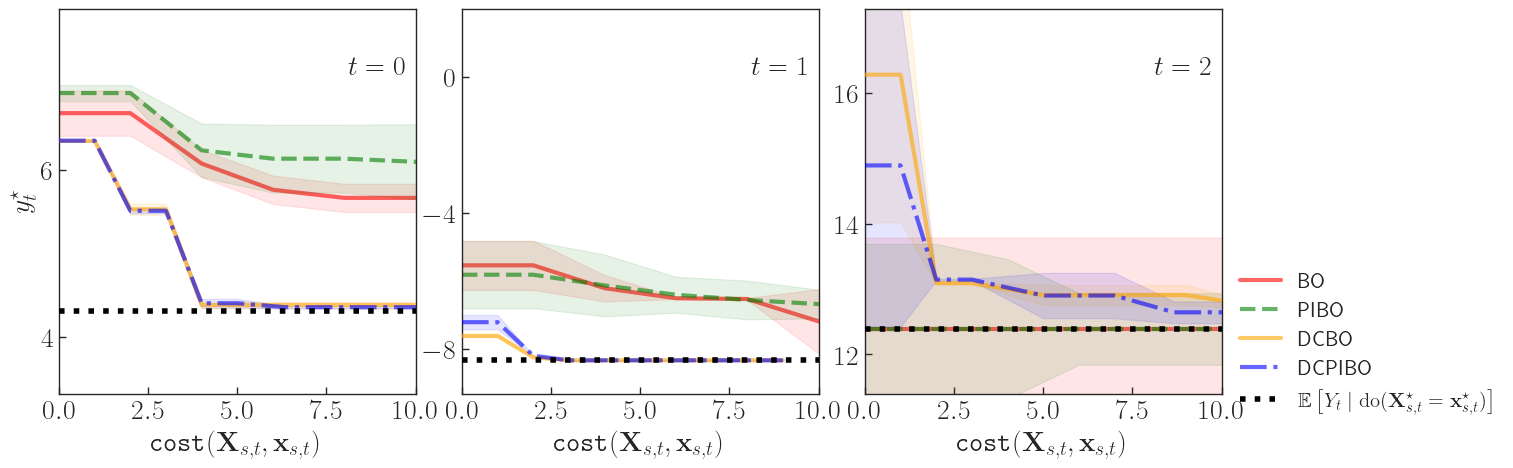

In [22]:
# Each frame corresponds to one time-slice.
plot_expected_opt_curve_paper(T,
    true_objective_values,
    good_exp_per_trial_cost,
    good_exp_optimal_outcome_values_during_trials,
    plot_params,  
    fig_size = (15,5))

### Bad prior

In [23]:
bad_data = get_relevant_results(results=bad_results,replicates=R)
bad_exp_optimal_outcome_values_during_trials, bad_exp_per_trial_cost = elaborate(number_of_interventions=None, 
                                                                         n_replicates=R, 
                                                                         data=bad_data, 
                                                                         best_objective_values=true_objective_values, 
                                                                         T=T)

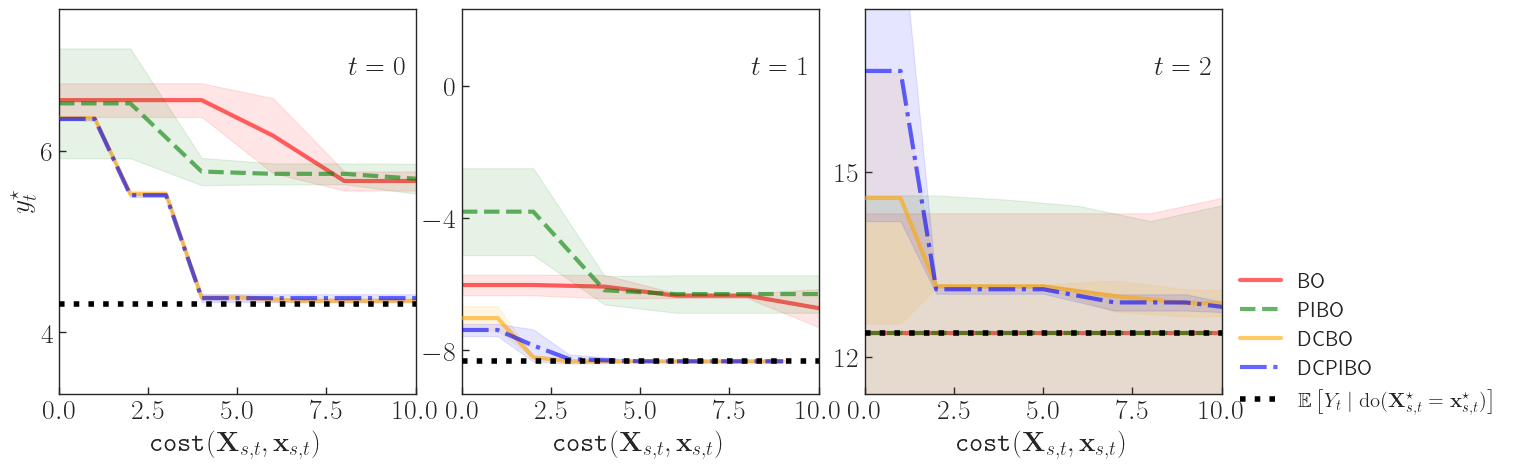

In [24]:
# Each frame corresponds to one time-slice.
plot_expected_opt_curve_paper(T,
    true_objective_values,
    bad_exp_per_trial_cost,
    bad_exp_optimal_outcome_values_during_trials,
    plot_params,  
    fig_size = (15,5))

### Very bad prior

In [25]:
# very_bad_data = get_relevant_results(results=very_bad_results,replicates=R)
# very_bad_exp_optimal_outcome_values_during_trials, very_bad_exp_per_trial_cost = elaborate(number_of_interventions=None, 
#                                                                          n_replicates=R, 
#                                                                          data=very_bad_data, 
#                                                                          best_objective_values=true_objective_values, 
#                                                                          T=T)

In [26]:
# # Each frame corresponds to one time-slice.
# plot_expected_opt_curve_paper(T,
#     true_objective_values,
#     very_bad_exp_per_trial_cost,
#     very_bad_exp_optimal_outcome_values_during_trials,
#     plot_params,  
#     fig_size = (15,5))

## Gap Metric

In [27]:
def compute_gap_values(T, summary):
    G_BO=0
    G_PIBO=0
    G_DCBO=0
    G_DCPIBO=0
    list_gaps=[]
    summary_list = list(summary.values())
    for i in range(len(summary_list)):
        for t in range(T):
            # print(summary_list[i][t][0])
            if i==0:
                G_BO=G_BO+summary_list[i][t][0]
                if t==2:
                    list_gaps.append(G_BO/T)
            elif i==1:
                G_PIBO=G_PIBO+summary_list[i][t][0]
                if t==2:
                    list_gaps.append(G_PIBO/T)
            elif i==2:
                G_DCBO=G_DCBO+summary_list[i][t][0]
                if t==2:
                    list_gaps.append(G_DCBO/T)
            elif i==3:
                G_DCPIBO=G_DCPIBO+summary_list[i][t][0]
                if t==2:
                    list_gaps.append(G_DCPIBO/T)
    return list_gaps

### Good Gap Metric

In [28]:
good_t_i_l = get_common_initial_values(T=T,
                                  data=good_data,
                                  n_replicates=R)

good_w_c_d = get_converge_trial(best_objective_values=true_objective_values,
                           exp_optimal_outcome_values_during_trials=good_exp_optimal_outcome_values_during_trials,
                           n_trials=N,
                           T=T,
                           n_decimal=1)

good_summary = gap_metric_standard(T=T,
                             data=good_data,
                             best_objective_values=true_objective_values,
                             total_initial_list = good_t_i_l,
                             n_replicates=R,
                             n_trials=N,
                             where_converge_dict=good_w_c_d)

good_list = compute_gap_values(T, good_summary)

In [29]:
good_summary

{'BO': [[0.284955420206662, 0.0056744182706130256],
  [0.3039829503237192, 0.16352516026157118],
  [1.0526315789473684, 0.0]],
 'PIBO': [[0.27817256332098544, 0.00870891888014328],
  [0.28626108115371846, 0.07097308226695268],
  [1.0526315789473684, 0.0]],
 'DCBO': [[0.5757161726641825, 0.001268983628286156],
  [0.8947368421052632, 0.0],
  [0.4619565458688408, 0.038978154797648046]],
 'DCPIBO': [[0.5180742201417577, 0.0032906398304759],
  [0.8947368421052632, 0.0],
  [0.49694638928433194, 0.033827517202122064]]}

In [30]:
good_list

[0.5471899831592498,
 0.5390217411406907,
 0.6441365202127621,
 0.6365858171771176]

### Bad Gap Metric

In [31]:
bad_t_i_l = get_common_initial_values(T=T,
                                  data=bad_data,
                                  n_replicates=R)

bad_w_c_d = get_converge_trial(best_objective_values=true_objective_values,
                          exp_optimal_outcome_values_during_trials=bad_exp_optimal_outcome_values_during_trials,
                          n_trials=N,
                          T=T,
                          n_decimal=1)

bad_summary = gap_metric_standard(T=T,
                             data=bad_data,
                             best_objective_values=true_objective_values,
                             total_initial_list = bad_t_i_l,
                             n_replicates=R,
                             n_trials=N,
                             where_converge_dict=bad_w_c_d)

bad_list = compute_gap_values(T, bad_summary)

In [32]:
bad_summary

{'BO': [[0.2750503485090327, 0.020988762495806706],
  [0.37919479343365853, 0.1530649042838048],
  [1.0526315789473684, 0.0]],
 'PIBO': [[0.270539679191542, 0.020707680508233756],
  [0.32869633595712855, 0.1438387665972734],
  [1.0526315789473684, 0.0]],
 'DCBO': [[0.7305533715799631, 0.004275406879512327],
  [0.8947368421052632, 0.0],
  [0.45197894426153246, 0.05712152086554912]],
 'DCPIBO': [[0.5132968908631727, 0.010115294882290316],
  [0.8947368421052632, 0.0],
  [0.4299757875451813, 0.0968927289799482]]}

In [33]:
bad_list

[0.5689589069633532,
 0.5506225313653462,
 0.6924230526489196,
 0.6126698401712057]